# Corporate Tax Rates and the Largest Stock Exchanges

# ETL

### Import Utils

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_theme()

from sklearn.linear_model import LinearRegression

### Import Data

Import key index from each countries largest stock exchange

In [157]:
bse_index    = pd.read_csv('BSE.index.bse.csv')
ftse_index   = pd.read_csv('FTSE.index.GBP.csv')
gdaxi_index  = pd.read_csv('GDAXI.index.eur.csv')
gsptse_index = pd.read_csv('GSPTSE.composite.cad.csv')
hsi_index    = pd.read_csv('HSI.index.hkd.csv')
kospi_index  = pd.read_csv('KOSPI.composite.krw.csv')
n225_index   = pd.read_csv('N225.index.jpy.csv')
nya_index    = pd.read_csv('NYA.composite.usd.csv')
sse_index    = pd.read_csv('SSE.composite.csy.csv')
ssmi_index   = pd.read_csv('SSMI.index.chf.csv')

Import corporate tax rates, inflation, and unemployment sourced from yahoo finance and the world bank.

In [158]:
corporate_tax_rates = pd.read_excel('corporate.tax.rates.xlsx')
inflation_rates     = pd.read_csv('inflation.csv')
unemployment_rates  = pd.read_csv('unemployment rate.csv')

# Data Preperation

## Corporate Tax Rates and GDP Data Quality Check and Tranformation

First, we check to make sure that the data was imported correctly.

In [159]:
corporate_tax_rates.head()

,iso_2,iso_3,continent,country,year,rate,gdp,oecd,eu27,gseven,gtwenty,brics
0,AW,ABW,NO,Aruba,1980,NaN,NaN,0,0,0,0,0
1,AW,ABW,NO,Aruba,1981,NaN,NaN,0,0,0,0,0
2,AW,ABW,NO,Aruba,1982,NaN,NaN,0,0,0,0,0
3,AW,ABW,NO,Aruba,1983,NaN,NaN,0,0,0,0,0
4,AW,ABW,NO,Aruba,1984,NaN,NaN,0,0,0,0,0


Next, we filter the `corporate tax rates` data removing country grouping data, and keeping only our chosen countries.

In [160]:
corporate_tax_rates = corporate_tax_rates.drop( columns=['iso_2','iso_3','continent','oecd','eu27','gseven','gtwenty','brics'] )

country_list = ['United States of America', 'United Kingdom of Great Britain and Northern Ireland','Germany', 'Japan','China' ]

filtered_corporate_tax_rates = corporate_tax_rates[corporate_tax_rates['country'].isin(country_list)]

ctr = filtered_corporate_tax_rates

ctr['country'] = ctr['country'].replace({
  'United States of America': 'United States',
  'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
})

ctr['gdp_change'] = ctr['gdp'].pct_change()

print(ctr.shape)

(205, 5)


<ipython-input-160-50aff51e191b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctr['country'] = ctr['country'].replace({
<ipython-input-160-50aff51e191b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctr['gdp_change'] = ctr['gdp'].pct_change()


Finally, we check for missing values in `corporate_tax_rates`.

In [161]:
ctr_na = ctr.loc[ ctr.isnull().any(axis=1) ]

ctr_na.head()

,country,year,rate,gdp,gdp_change
1804,China,1980,55.2,341.361816,NaN
2460,Germany,1980,NaN,2040.544067,-0.832946
4756,Japan,1980,NaN,3019.286621,0.028508
4757,Japan,1981,NaN,3146.378418,0.042093
4758,Japan,1982,NaN,3250.601074,0.033125


We remove the rows that contained missing values, cutting all before 1983.

In [162]:
ctr = ctr.loc[ ctr['year'] >= 1984 ]

ctr = ctr.astype({
  'year':'int32',
  'rate':'float64',
  'gdp':'float64',
  'gdp_change':'float64'
})

ctr.head()

,country,year,rate,gdp,gdp_change
1808,China,1984,40.0,499.094574,0.151392
1809,China,1985,40.0,566.189819,0.134434
1810,China,1986,40.0,616.805481,0.089397
1811,China,1987,40.0,688.903442,0.116889
1812,China,1988,40.0,766.298401,0.112345


Given that there are missing value in the 80's. This decade will be ignored.

## Inflation Rates Data Quality Check and Tranformation

First, we look at inflation rates data to make sure it was imported properly.

In [163]:
inflation_rates.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,4.316297,0.627472,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,8.971206,9.158707,5.746949,5.370290,5.250171,6.594604,6.399343,4.720811,3.923372,4.978097
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,11.804186,6.441213,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN
3,Africa Western and Central,AFW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,4.018699,4.578375,2.439201,1.758052,2.130268,1.494564,1.764635,1.481021,1.758565,2.425007
4,Angola,AGO,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,13.482468,10.277905,8.777814,7.280387,9.150372,30.695313,29.843587,19.628608,17.081215,NaN


Next, we filter inflation rates data removing columns that don't include data that we need like `Country Code`, `Indicator Name`, and `Indicator Code`.

In [164]:
country_list = ['United States','United Kingdom','Germany', 'Japan','China' ]

filtered_inflation_rates = inflation_rates[ inflation_rates['Country Name'].isin(country_list) ]

ir = filtered_inflation_rates.drop( columns=['Country Code', 'Indicator Name', 'Indicator Code'] )

ir.head()

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
40,China,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.553899,2.619524,2.621050,1.921642,1.437024,2.000002,1.593136,2.074790,2.899234,2.419422
55,Germany,1.536612,2.293676,2.843280,2.966961,2.335728,3.242329,3.533059,1.796046,1.470304,...,2.075175,2.008491,1.504721,0.906798,0.514421,0.491749,1.509497,1.732168,1.445667,0.506690
81,United Kingdom,1.003576,3.447496,4.196499,2.018544,3.281587,4.773775,3.909618,2.482116,4.697428,...,3.856112,2.573235,2.291667,1.451120,0.368047,1.008417,2.557756,2.292840,1.738105,0.989487
119,Japan,3.574512,5.368462,6.835440,6.706906,3.800389,6.655991,5.040832,3.989848,5.339433,...,-0.267634,-0.051939,0.346440,2.761954,0.789518,-0.116667,0.467212,0.979904,0.476974,-0.016369
251,United States,1.457976,1.070724,1.198773,1.239669,1.278912,1.585169,3.015075,2.772786,4.271796,...,3.156842,2.069337,1.464833,1.622223,0.118627,1.261583,2.130110,2.442583,1.812210,1.233584


Finally, we check to see if there is any missing data.

In [165]:
ir_na = ir.loc[ :, ir.isnull().any(axis=0) ]

ir_na.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,1.536612,2.293676,2.843280,2.966961,2.335728,3.242329,3.533059,1.796046,1.470304,1.912664,...,3.734168,2.718691,4.043622,5.441056,6.344241,5.241047,3.293415,2.405795,2.066231,-0.129413
81,1.003576,3.447496,4.196499,2.018544,3.281587,4.773775,3.909618,2.482116,4.697428,5.446664,...,15.840267,8.263141,13.421280,17.965924,11.876627,8.598864,4.609303,4.960711,6.071394,3.427609
119,3.574512,5.368462,6.835440,6.706906,3.800389,6.655991,5.040832,3.989848,5.339433,5.249821,...,8.161827,4.209566,3.701851,7.778582,4.912163,2.741041,1.899720,2.261614,2.032277,0.595587
251,1.457976,1.070724,1.198773,1.239669,1.278912,1.585169,3.015075,2.772786,4.271796,5.462386,...,6.501684,7.630964,11.254471,13.549202,10.334715,6.131427,3.212435,4.300535,3.545644,1.898048


We then remove rows with missing data and convert to tall form for easier calculations.

In [166]:
ir = ir.loc[ :, ir.isnull().any(axis=0) == False ]

years = ir.columns[1:]

ir = ir.melt( id_vars=['Country Name'], value_vars=years )
ir = ir.sort_values( by=['Country Name', 'variable' ] )
ir = ir.rename( columns={ 
  'Country Name':'country',
  'variable':'year', 
  'value':'inflation_rate'
})

ir['inflation_change'] = ir['inflation_rate'].pct_change()

ir = ir.astype({
  'year': 'int32',
  'inflation_rate': 'float64',
  'inflation_change': 'float64'
})

ir.head()

,country,year,inflation_rate,inflation_change
0,China,1987,7.233836,NaN
5,China,1988,18.811818,1.600532
10,China,1989,18.245638,-0.030097
15,China,1990,3.052290,-0.832711
20,China,1991,3.556686,0.165252


## Unemployment Rates Data Quality Check and Transformation

First, we check that the data was imported successfully.

In [167]:
unemployment_rates.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,6.730720,6.578243,6.480673,6.414462,6.468598,6.546351,6.523061,6.414392,6.472269,6.814177
2,Afghanistan,AFG,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,11.510000,11.520000,11.540000,11.450000,11.390000,11.310000,11.180000,11.060000,10.980000,11.730000
3,Africa Western and Central,AFW,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,4.466731,4.560139,4.356187,4.640632,4.547113,5.486480,5.927104,5.910615,5.928926,6.300105
4,Angola,AGO,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,7.360000,7.370000,7.380000,7.310000,7.260000,7.200000,7.100000,7.000000,6.930000,7.700000


Next, we narrow down our data to our selected countries.

In [168]:
country_list = ['United States', 'United Kingdom', 'Germany', 'Japan','China' ]

filtered_unemployment_rates = unemployment_rates[ unemployment_rates['Country Name'].isin(country_list) ]

ur = filtered_unemployment_rates.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])

ur

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
40,China,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.50,4.60,4.60,4.60,4.60,4.50,4.40,4.30,4.60,5.00
55,Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.82,5.38,5.23,4.98,4.62,4.12,3.75,3.38,3.14,4.31
81,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.04,7.89,7.52,6.11,5.30,4.81,4.33,4.00,3.74,4.34
119,Japan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.52,4.30,4.00,3.60,3.40,3.10,2.80,2.40,2.40,2.97
251,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.95,8.07,7.38,6.17,5.28,4.87,4.36,3.90,3.67,8.31


Finally, check for any missing values

In [169]:
ur_na = ur.loc[ :, ur.isnull().any(axis=0) ]

ur_na.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Remove rows with missing values.

In [170]:
ur = ur.loc[ :, ur.isnull().any(axis=0) == False ]

years = ur.columns[1:]

ur = ur.melt( id_vars=['Country Name'], value_vars=years )
ur = ur.sort_values( by=['Country Name', 'variable' ] )
ur = ur.rename( columns={ 
  'Country Name':'country',
  'variable':'year', 
  'value':'unemployment_rate'
})

ur['unemployment_change'] = ur['unemployment_rate'].pct_change()

ur = ur.astype({
  'year': 'int32',
  'unemployment_rate': 'float64',
  'unemployment_change': 'float64'
})

ur.head()

,country,year,unemployment_rate,unemployment_change
0,China,1991,2.4,NaN
5,China,1992,2.4,0.000000
10,China,1993,2.7,0.125000
15,China,1994,2.9,0.074074
20,China,1995,3.0,0.034483


In [171]:
ctr['country'].unique()

array(['China', 'Germany', 'United Kingdom', 'Japan', 'United States'],
      dtype=object)

## Merge Dataframe

In [172]:
# user inner join so that only valid years are included for all metrics

df = ctr.merge(
  ur,
  on=['country', 'year'],
).merge(
  ir,
  on=['country', 'year']
)

df.head()


,country,year,rate,gdp,gdp_change,unemployment_rate,unemployment_change,inflation_rate,inflation_change
0,China,1991,40.0,906.668762,0.092941,2.4,NaN,3.556686,0.165252
1,China,1992,30.0,1035.562256,0.142162,2.4,0.000000,6.353981,0.786489
2,China,1993,30.0,1179.169678,0.138676,2.7,0.125000,14.610079,1.299358
3,China,1994,33.0,1333.076782,0.130522,2.9,0.074074,24.256990,0.660292
4,China,1995,33.0,1479.038330,0.109492,3.0,0.034483,16.791225,-0.307778


# Data Exploration

### GDP vs Year

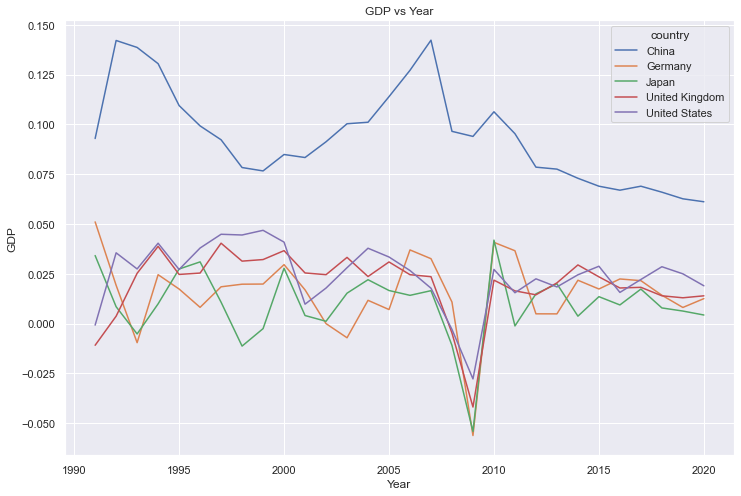

In [173]:
_ = df.pivot_table(values='gdp_change', index='year', columns='country').plot(figsize=(12,8))

_ = plt.xlabel('Year')
_ = plt.ylabel('GDP')

_ = plt.title('GDP vs Year')

plt.show()

Then we use pandas build in plot function to create a line plot by country.

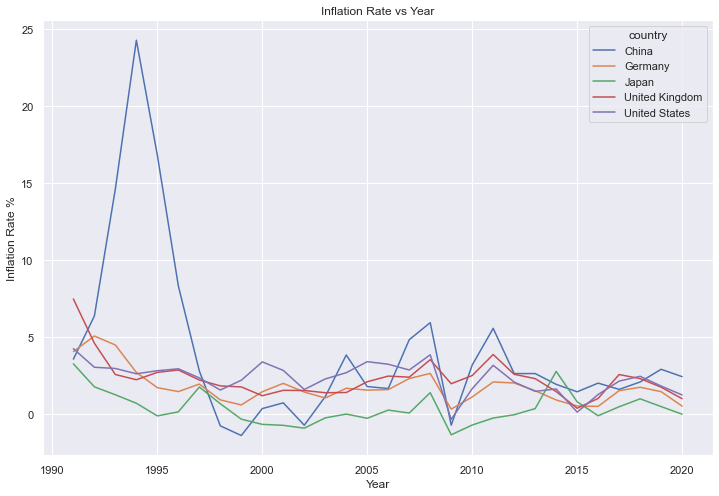

In [174]:
_ = df.pivot_table(values='inflation_rate', index='year', columns='country').plot(figsize=(12,8))

_ = plt.xlabel('Year')
_ = plt.ylabel('Inflation Rate %')

_ = plt.title('Inflation Rate vs Year')

plt.show()

We then use the build in plot function in pandas to plot the inflation rate by year and country.

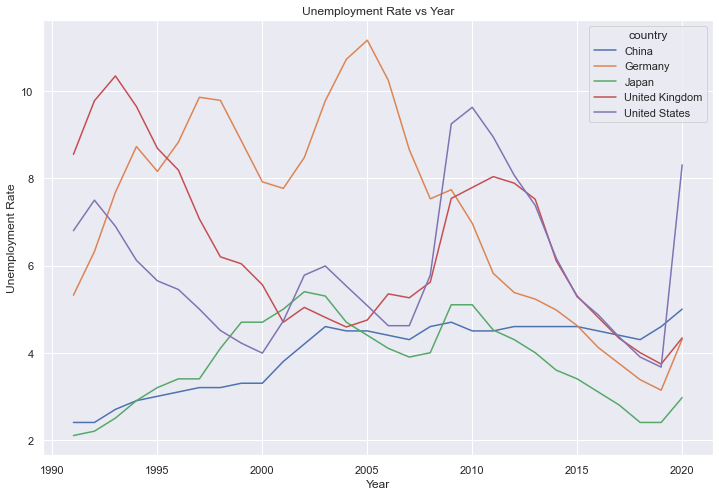

In [175]:
_ = df.pivot_table( values='unemployment_rate', index='year', columns='country' ).plot( figsize=(12,8) )

_ = plt.xlabel('Year')
_ = plt.ylabel('Unemployment Rate')

_ = plt.title('Unemployment Rate vs Year')

plt.show()

# Globalization in GDP

Globalization has to do with the increasing interconnectedness of nations internationally. To investigate the rate of globalization, we will take data since 1991 of 10 nations in terms of gdp, inflation rate, and unemployment and see if the correlations between nations in terms of these variables are increasing.

Timeseries Correlation Function

In [176]:

def compute_ts_correlation( start_year, end_year, country_1, country_2, metric ):
  df_base = df.loc[(df['year'] >= start_year) & (df['year'] < end_year)]

  df_1 = df_base[ df_base['country'] == country_1 ]
  df_2 = df_base[ df_base['country'] == country_2 ]

  r, p = stats.pearsonr( df_1[metric], df_2[metric] )

  return r, p

In [177]:
def compute_ts_block_correlation( country_1, country_2, metric ):
  outputs = []

  for i in range( 1995, 2020, 5 ):
    r, p = compute_ts_correlation( i, i+5, country_1, country_2, metric )

    outputs.append( [r, p] )
  
  return outputs 

In [187]:

def get_average_correlation( metric, countries ):
  used_countries = []
  correlations = [
    [],
    [],
    [],
    [],
    []
  ]
  out = []
  for country_1 in countries:
    used_countries.append( country_1 )

    for country_2 in countries:

      if country_2 in used_countries:
        continue

      if country_1 == country_2:
        continue

      outputs = compute_ts_block_correlation( country_1, country_2, metric )

      for i in range( 0, 5 ):
        correlations[i].append( abs(outputs[i][0]) )

  for period in correlations:
    total = 0

    for correlation in period:

      total += correlation

    out.append( total / len(period) )

  return out


In [204]:

countries = [ 'China', 'United States' ]

print( get_average_correlation( 'unemployment_change', countries ) )


[0.6336148897128071, 0.8939508809893971, 0.5802858965122135, 0.7809126031161591, 0.5050874225141104]
